# Module 9: 异常检测 Anomaly Detection

异常检测是识别特性与其余数据明显不同的实例的任务。在本教程中，我们将提供使用Python及其库包应用不同的异常检测技术的示例。

请仔细阅读下面的分步说明。 要执行代码，请单击相应的单元格，然后同时按SHIFT-ENTER键。

**<font color ='red'>思考：</font>** 
1. 尝试对比分析使用参数的异常检测模型与基于距离的异常检测方法的特点（包括但不限于方法理论、原理、实验结果等）


## 9.1 使用参数模型 Using Parametric Models 

该方法假定大多数数据实例由某些众所周知的概率分布，例如二项分布（Binomial distribution）或高斯分布（Gaussian distribution）支配。 然后可以通过寻找不适合数据整体分布的观察结果来检测异常。

在此示例中，我们的目标是检测各种股票的每日收盘价中的异常变化。输入数据*stocks.csv* 包含3家大型公司（微软、福特汽车公司和美国银行）的股票历史收盘价。

**<font color ='red'>任务：</font>** 
1. 运行下述代码，并通过查阅sckit-learn、pandas文档等方式了解异常检测中的数据处理和参数模型的实现原理和使用过程；
2. 尝试修改参数模型的各种设置，观察是否会影响实验结果。

**<font color ='red'>思考：</font>** 
对以下数据集使用参数模型，并简述你的观察结果与相关分析
1. 对本tutorial中的股票集“stocks.csv”中的一个或者两个维度进行异常分析
2. 对“tutorial4_Data Preprocessing”中的降水量据集“DTW_prec.csv”进行不同尺度（例如年月日）的聚合预处理，然后再对降水量及其变化进行异常分析

In [2]:
import pandas as pd

stocks = pd.read_csv('stocks.csv', header='infer' ) 
stocks.index = stocks['Date']
stocks = stocks.drop(['Date'],axis=1)
stocks.head()

,MSFT,F,BAC
Date,,,
1/3/2007,29.860001,7.51,53.330002
1/4/2007,29.809999,7.70,53.669998
1/5/2007,29.639999,7.62,53.240002
1/8/2007,29.930000,7.73,53.450001
1/9/2007,29.959999,7.79,53.500000


我们可以用如下公式计算每只股票每日收盘价（closing price）变化的百分比：
\begin{equation}
\Delta(t) = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}} 
\end{equation}

其中 $x_t$ 表示股票在某天（$t$）的价格，$x_{t-1}$ 表示该股票在前一天（$t-1$）的价格.

In [3]:
import numpy as np

N,d = stocks.shape
delta = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values-stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values),
                    columns=stocks.columns, index=stocks.iloc[1:].index)
delta.head()

,MSFT,F,BAC
Date,,,
1/4/2007,-0.167455,2.529960,0.637532
1/5/2007,-0.570278,-1.038961,-0.801185
1/8/2007,0.978411,1.443570,0.394438
1/9/2007,0.100231,0.776197,0.093543
1/10/2007,-1.001332,-0.770218,0.149536


我们可以绘制股价每日变化百分比的分布图。

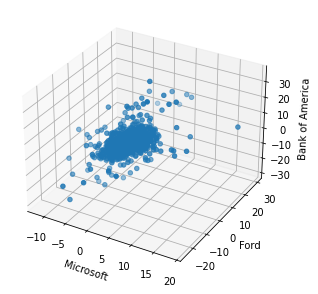

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,5)).gca(projection='3d')
fig.scatter(delta.MSFT,delta.F,delta.BAC)
fig.set_xlabel('Microsoft')
fig.set_ylabel('Ford')
fig.set_zlabel('Bank of America')
plt.show()

假设数据服从多元高斯分布，则可以按照如下方式计算3维数据的均值和协方差矩阵


In [5]:
meanValue = delta.mean()
covValue = delta.cov()
print(meanValue)
print(covValue)

MSFT    0.045003
F       0.061374
BAC     0.033351
dtype: float64
          MSFT         F        BAC
MSFT  3.191674  2.136351   2.788870
F     2.136351  8.524944   4.997405
BAC   2.788870  4.997405  13.770761


要确定异常交易日，我们可以计算每天的价格变化百分比与平均价格变化百分比之间的马氏距离（Mahalanobis distance）。
\begin{equation}
\textrm{Mahalanobis}(x) = (x - \bar{x}) \Sigma^{-1}(x - \bar{x})^T
\end{equation}
其中 $x$ 是一个行向量.

**<font color ='red'>思考：</font>** 
请查阅相关资料或者进行搜索，分析
1. 马氏距离的优缺点
2. 列举一下马氏距离适用的场景

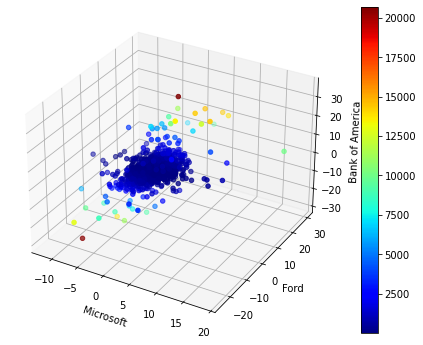

In [6]:
from numpy.linalg import inv

X = delta.values
S = covValue.values
for i in range(3):
    X[:,i] = X[:,i] - meanValue[i]
    
def mahalanobis(row):
    return np.matmul(row,S).dot(row)   
    
anomaly_score = np.apply_along_axis( mahalanobis, axis=1, arr=X)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=anomaly_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

前2个异常在上图中显示为棕点。 最高的异常对应于所有3只股票的价格显着上涨的当天，而第二高的异常对应于所有3只股票的收盘价格下跌很大的一天。 我们可以检查与前2个最高异常分数相关的日期，如下所示。

**<font color ='red'>任务：</font>** 
1. 请寻找其他异常值较高的点，并分析其特征及相应的数据。

**<font color ='red'>思考：</font>** 
1. “所有3只股票的收盘价格下跌”是什么时候出现的，请尝试通过网络搜索等方式分析为何当时出现了“所有3只股票的收盘价格下跌”的情况


In [7]:
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta,anom), axis=1)
result.nlargest(2,'Anomaly score')

,MSFT,F,BAC,Anomaly score
Date,,,,
4/9/2009,2.456295,7.280398,35.235771,20691.465032
10/7/2008,-6.789282,-20.928583,-26.259300,20471.095209


Text(0, 0.5, 'Percent Change')

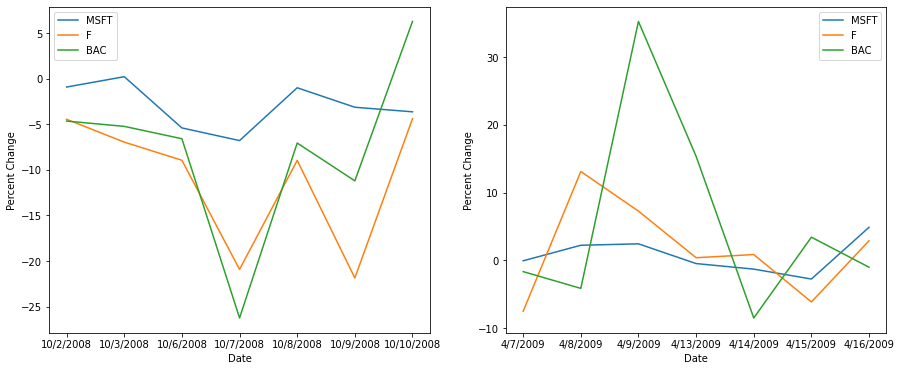

In [8]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ts = delta[440:447]
ts.plot.line(ax=ax1)
ax1.set_xticks(range(7))
ax1.set_xticklabels(ts.index)
ax1.set_ylabel('Percent Change')

ts = delta[568:575]
ts.plot.line(ax=ax2)
ax2.set_xticks(range(7))
ax2.set_xticklabels(ts.index)
ax2.set_ylabel('Percent Change')

## 9.2 基于距离的方法 Using Distance-based Approach


这是一种无需模型（model-free）的异常检测方法，因为它不需要构造正常数据的显式模型来确定数据实例的异常评分。下面显示的示例代码采用k最近邻方法来计算异常分数。具体而言，正常实例预计与其第k个最近邻居的距离较小，而异常可能与其第k个最近邻居的距离较大。 在下面的示例中，我们应用基于距离的方法（k = 4）从上一节中描述的股市数据中识别异常交易日。

**<font color ='red'>任务：</font>** 
1. 运行下述代码，并通过查阅sckit-learn、pandas文档等方式了解异常检测中的数据处理和基于距离的异常检测方法的实现原理和使用过程；
2. 尝试修改参数模型的各种设置（例如k值），观察是否会影响实验结果。

**<font color ='red'>思考：</font>** 
对以下数据集使用基于距离的异常方法，并简述你的观察结果与相关分析
1. 对“tutorial4_Data Preprocessing”中的癌症据集“breast-cancer-wisconsin.data”中的一个或者多个维度进行异常分析

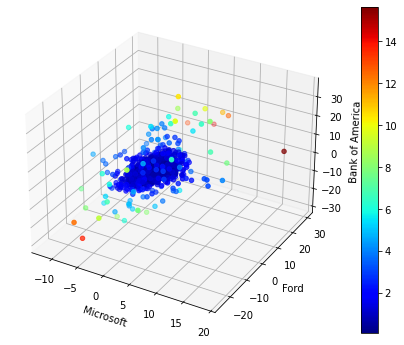

In [12]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import distance

knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(delta.values) #euclidean
distances, indices = nbrs.kneighbors(delta.values)

anomaly_score = distances[:,knn-1]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=anomaly_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

由于我们使用欧几里德距离（而不是马氏距离）来检测异常，所以结果与前面显示的结果略有不同。 

**<font color ='red'>思考：</font>** 
请查阅相关资料或者进行搜索，分析
1. 马氏距离和欧式距离的特点对比
2. 马氏距离和欧式距离的在本教程的异常检测的结果的对比分析

我们可以检查与前5个最高异常分数相关的日期，如下所示。

In [10]:
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])
result = pd.concat((delta,anom), axis=1)
result.nlargest(5,'Anomaly score')

,MSFT,F,BAC,Anomaly score
Date,,,,
4/9/2009,2.456295,7.280398,35.235771,20691.465032
10/7/2008,-6.789282,-20.928583,-26.259300,20471.095209
7/16/2008,4.199739,18.003142,22.374857,14586.725381
3/10/2009,8.733875,6.260465,27.699983,14460.021473
11/24/2008,5.087116,9.029535,27.168044,14360.912124


Text(0, 0.5, 'Percent Change')

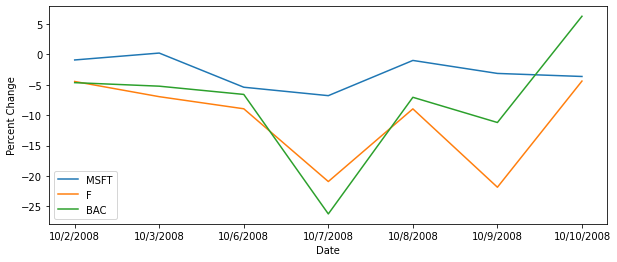

In [11]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
# ts = delta[445:452]
ts = delta[440:447]
ts.plot.line(ax=ax)
# ax.set_xticks(range(7))
ax.set_xticks(range(7))
ax.set_xticklabels(ts.index)
ax.set_ylabel('Percent Change')

## 9.3 总结 Summary

本教程说明了将异常检测方法应用于多元时间序列数据的示例。 我们考虑两种方法，一种是基于使用多元高斯（multivariate Gaussian）的参数统计方法，另一种是使用k最近邻（k-nearest neighbor）的基于非参数（nonparametric）距离的方法。